# Analyse quality of pyjetjet clustering
Find difference in positon, pt, and number of constituents between my jet and reco jet.

My jets can be clustered in several ways: no pileup, puppi weights, and CHS

In [1]:
import numpy as np
from numpy.lib.recfunctions import append_fields
import matplotlib.pyplot as plt
import matplotlib as mpl
import uproot
import awkward as ak
import pyjet
import time

from matching import matching

plt.style.use("scientific.mplstyle")

file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

In [2]:
max_idx = 200

pts = event_tree['PF_pt'].array(entry_stop=max_idx, library='np')
etas = event_tree['PF_eta'].array(entry_stop=max_idx, library='np')
phis = event_tree['PF_phi'].array(entry_stop=max_idx, library='np')
masses = event_tree['PF_mass'].array(entry_stop=max_idx, library='np')

puppi_weights = event_tree['PF_puppiWeight'].array(entry_stop=max_idx, library='np')
pv_labels = event_tree['PF_fromPV'].array(entry_stop=max_idx, library='np')

recojet_pts = event_tree['Jet_pt'].array(entry_stop=max_idx, library='np')
recojet_etas = event_tree['Jet_eta'].array(entry_stop=max_idx, library='np')
recojet_phis = event_tree['Jet_phi'].array(entry_stop=max_idx, library='np')
recojet_masses = event_tree['Jet_mass'].array(entry_stop=max_idx, library='np')
recojet_nconst = event_tree['Jet_nConstituents'].array(entry_stop=max_idx, library='np')

raw_pt_factor = 1-event_tree['Jet_rawFactor'].array(entry_stop=max_idx, library='np')
pf_recojetidx = event_tree['PF_jetsIdx'].array(entry_stop=max_idx, library='np')

In [6]:
def manual_jet_clustering(pts, etas, phis, masses, puppi_weights, use_puppi, pv_labels, use_chs):
    '''Cluster jets for one event with anti kt, 15 Gev pt cut off, and using puppi pileup mitigation if use_puppi=True, CHS if use_chs=True or otherwise no pileup is mitigated.
    It is assumed that only PF candidates with a non-zero puppi weight are physical. A pt=0 particle travels a long the beam axis and never hits the detector.'''
    if use_puppi:
        pts = pts*puppi_weights 

    event_4vect = np.column_stack((pts, etas, phis, masses)).astype('float64')
    event = np.core.records.fromarrays(event_4vect.transpose(), dtype=pyjet.DTYPE_PTEPM)
    event = append_fields(event, 'id', data=np.arange(len(event))).data
    
    if use_puppi:
    # only consider particles with non zero puppi weight
        physical_mask = np.where(puppi_weights!=0.0, True, False)
        event = event[physical_mask]
    elif use_chs:
        # pv_labels contains int for every particle in range 0,1,2,3. All particles with 0 are background
        chs_mask = np.where(pv_labels>0, True, False)
        event = event[chs_mask]

    sequence = pyjet.cluster(event, R=0.4, p=-1)
    my_jets = sequence.inclusive_jets(ptmin=15)
    
    return my_jets


def myjets_recojets_differences(use_puppi, use_chs):
    '''Finds list of all manually clustered jets (with puppi pileup mitigation if use_puppi=True) as well as their match to reco jets (each event being an element which is a list).
    Also finds differences in position, pt and # constituents between myjet and recojet.
    Additionally, finds particles  which have been missed or wrongly included in my clustering and returns an accuracy for the clustered constituents of myjet compared to recojet.'''
    n_myjets = 0 
    
    fully_correct_consti = 0 # number of jets with identical sets of constituents
    all_myjets, my_matchings, raw_reco_pts = [], [], []
    
    delta_Rs = [] # separation of jet axis
    norm_delta_pts = [] # Normalized difference in pt: (recopt-mypt)/recopt
    norm_delta_mass = [] # Normalized difference in mass: (recomass-mymass)/recomass
    norm_delta_ns = [] # Normalized difference in number of constituents (recojet_nconst-my_nconst)/recojet_nconst 

    accs = [] # ratio of recojet consti also in myjet
    missed_pf = [] # information about particle in reco jet but not in my jet
    excess_pf = [] # information about particle in my jet but not in reco jet
    
    for i in range(max_idx): 
        myjets = manual_jet_clustering(pts[i], etas[i], phis[i], masses[i], puppi_weights[i], use_puppi, pv_labels[i], use_chs) 
        all_myjets.append(myjets)
        n_myjets += len(myjets)
        myjets_etas, myjets_phis = [myjet.eta for myjet in myjets], [myjet.phi for myjet in myjets] 
        
        my_matching = matching(myjets_etas, myjets_phis, recojet_etas[i], recojet_phis[i])
        my_matchings.append(my_matching)

        
        myconsti_idx = []
        for jet in myjets:
            jet_consti = [consti.id for consti in jet]
            myconsti_idx.append(np.sort(jet_consti))

        recoconsti_idx = []
        for p in np.unique(pf_recojetidx[i])[1:]:
             recoconsti_idx.append(np.where(pf_recojetidx[i]==p)[0])
        
    
        # find differences for every made match in the currently considered event i
        for j, reco_idx in enumerate(my_matching):
            # skip when my found jet is fake (i.e couldn't be paired) or when difference in number of constituents is too large
            if reco_idx == -1:
                continue
            
#             if abs((recojet_nconst[i][reco_idx] - len(myconsti_idx[j]))/recojet_nconst[i][reco_idx]) > 1:
#                 print("Large difference in # constituents in event {} between my jet {} and reco jet {}".format(i, j, reco_idx))
#                 continue
                
            else:    
                # kinematic differences
                delta_eta = myjets[j].eta - recojet_etas[i][reco_idx]
                delta_phi = myjets[j].phi - recojet_phis[i][reco_idx] 
                delta_Rs.append(np.sqrt(delta_eta**2 + delta_phi**2))

                raw_recojet_pts = recojet_pts[i][reco_idx]*raw_pt_factor[i][reco_idx]
                raw_reco_pts.append(raw_recojet_pts)
                norm_delta_pts.append((raw_recojet_pts - myjets[j].pt)/raw_recojet_pts)

                # constituents differences 
                norm_delta_ns.append((recojet_nconst[i][reco_idx] - len(myconsti_idx[j]))/recojet_nconst[i][reco_idx])
                
                my_c, reco_c = set(myconsti_idx[j]), set(recoconsti_idx[reco_idx]) 
                
                if my_c == reco_c:
                    fully_correct_consti += 1
                    accs.append(1.0)
                    continue
                
                accs.append(len(my_c.intersection(reco_c))/len(reco_c))
            
                missed = reco_c.difference(my_c)
                for missed_idx in missed:
                    missed_pf.append((i,missed_idx,j)) # event, PF_idx, myjet idx
                    
                excess = my_c.difference(reco_c)
                for excess_idx in excess:
                    excess_pf.append((i,excess_idx,j)) # event, PF_idx, myjet idx
                    
    
    return all_myjets, n_myjets, my_matchings, delta_Rs, norm_delta_pts, raw_reco_pts, accs, norm_delta_ns, missed_pf, excess_pf, fully_correct_consti

In [7]:
t1 = time.time()
using_puppi = False
using_chs = True
myjets, n_myjets, my_matchings, delta_Rs, delta_pts, raw_reco_pts, consti_acc, delta_n, missed_idx, excess_idx, nfully_correct_jets = myjets_recojets_differences(using_puppi, using_chs)
t2 = time.time()
print("Clustering and finding differences for jets in {} events completed in {:.2f} sec".format(max_idx, t2-t1))

Clustering and finding differences for jets in 200 events completed in 2.48 sec


# Constituents

## Similarity

In [3]:
n_recojets = 0
for i in range(max_idx):
    n_recojets += len(np.where(recojet_pts[i]*raw_pt_factor[i]>15)[0])

In [4]:
n_recojets

1281

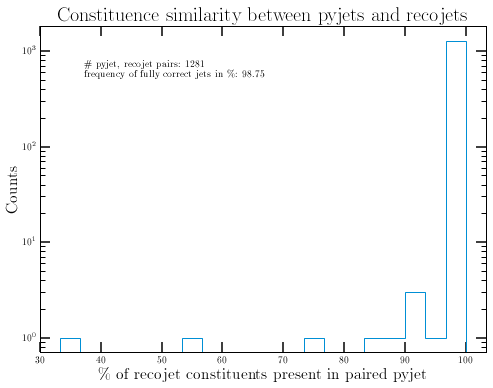

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.hist(np.asarray(consti_acc)*100, bins=20, histtype='step')
ax.set_yscale('log')
text = "\# pyjet, recojet pairs: {:.0f}\nfrequency of fully correct jets in \%: {:.2%}".format(len(consti_acc), nfully_correct_jets/len(consti_acc))

ax.text(0.1, 0.9, text, ha='left', va='top', transform = ax.transAxes)
ax.set_title("Constituence similarity between pyjets and recojets")
ax.set_xlabel("\% of recojet constituents present in paired pyjet")
ax.set_ylabel("Counts")

plt.show()
fig.savefig("plots/different_pileup_mitigation/constituents/similarity_chs.pdf")

In [9]:
print("Frequency of fully correct jets (my_constituents == reco_constituents): {:.2%}".format(nfully_correct_jets/len(consti_acc)))

Frequency of fully correct jets (my_constituents == reco_constituents): 98.75%


#### Conclusion

##### CHS
$98.91\%$ of all jets have correct set of constituents, indicating chs is correct pileup mitigation. All following error plots will thus only contain very few data points.


##### PUPPI
Only $6.8\%$ of all jets have exactly the correct constituents. With puppi weights, a large number of PF candidates is missed, leading to a relatively poor similarity. Note that a significant number of the missed particles has a large enough pt (compared to the hardest pt of the jet) to influence the jet axis significantly. Consider investigating this error further by plotting distance of missed particles from jet axis or hardest PF and check if these missed particles are considered in a different myjet (investigate why by considering separation of these two myjets and/or check the matching for this myjet).

Only few excess particles are produced with puppie weights.

##### NO PUPPI
Significant improvement in number of jets with exact constituents: $29.59\%$. As this time the dominant error are excess particle (7812 compared to 206), it is expected that the plotted similarity is much better than for puppi jets. The distribution of excess particles appears to be exponentiall distributed; much like general PF pt distribution, hinting that the excess particles are allmost all background. The number of missed particles is about a factor of 10 lower, compared to puppi jets (648 vs 6223) but covers a much larger range.  

## Missed

In [7]:
missedpf_pt, norm_missedpf_pt = [], []
missedpf_distance, missedpf_distance_other = [], [] # distance to myjet axis in which particle was missed and distance to myjet axis if particles clustered in a different myjet
missedpf_pt_unclustered = [] # pt of missed pf that are not clustered in any of my jet

for (event_idx, pf_idx, myjet_idx) in missed_idx:
    missedpf_pt.append(pts[event_idx][pf_idx])
    norm_missedpf_pt.append(pts[event_idx][pf_idx]/myjets[event_idx][myjet_idx].pt)
    
    d_eta = etas[event_idx][pf_idx] - myjets[event_idx][myjet_idx].eta
    d_phi = phis[event_idx][pf_idx] - myjets[event_idx][myjet_idx].phi
    missedpf_distance.append(np.sqrt(d_eta**2 + d_phi**2))
    
    # check if missed PF is used in a different myjet
    in_different_myjet = False
    for jet_idx, jet in enumerate(myjets[event_idx]):
        jet_consti = [consti.id for consti in jet]
        if pf_idx in jet_consti:
            in_different_myjet = True
            d_eta = etas[event_idx][pf_idx] - myjets[event_idx][jet_idx].eta
            d_phi = phis[event_idx][pf_idx] - myjets[event_idx][jet_idx].phi
            missedpf_distance_other.append(np.sqrt(d_eta**2 + d_phi**2))
            break
            
    if not in_different_myjet:
        missedpf_pt_unclustered.append(pts[event_idx][pf_idx])

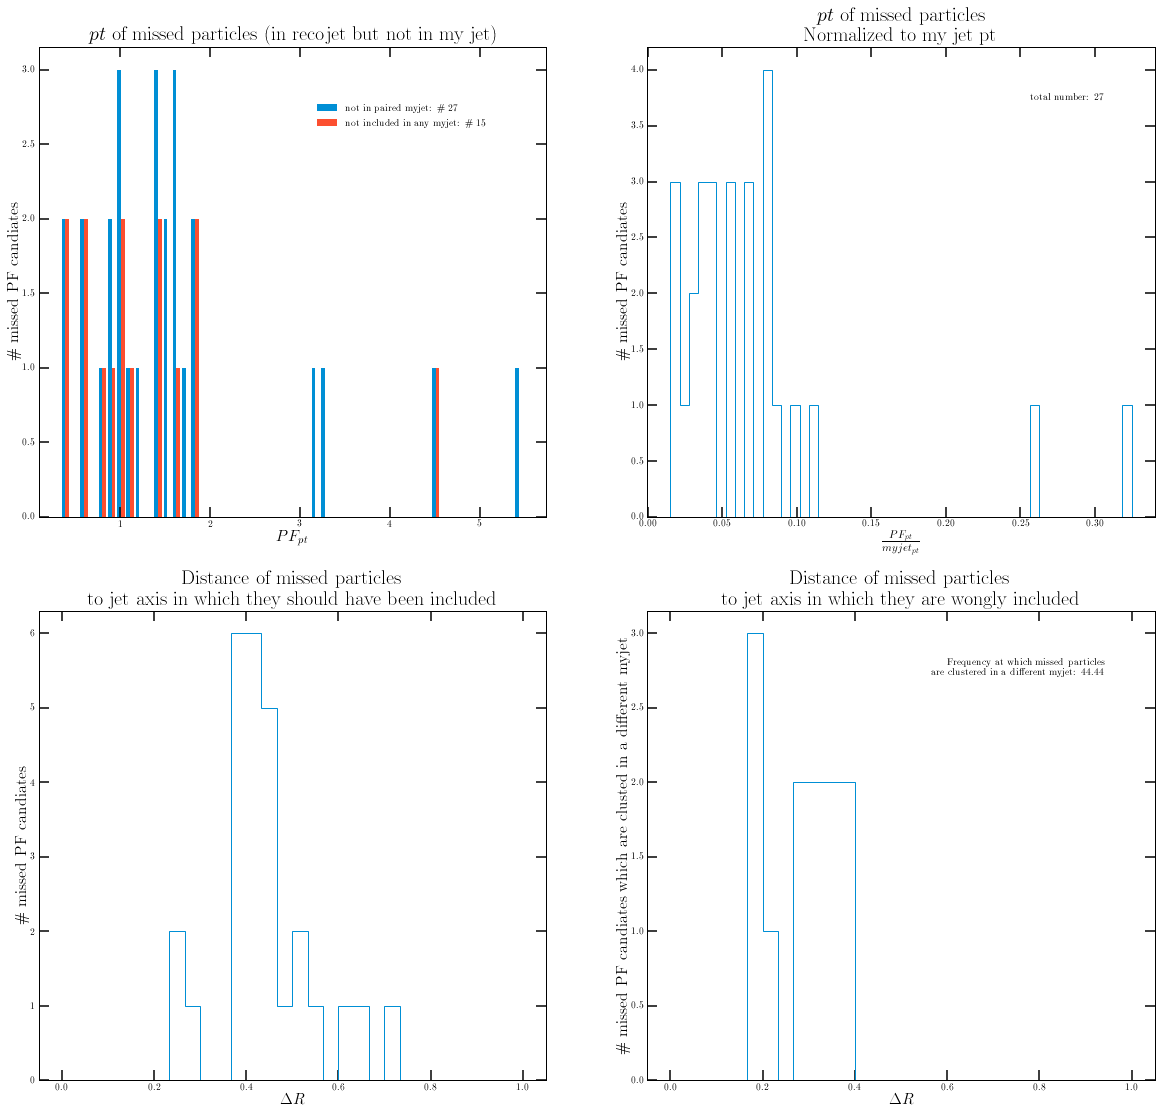

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 19))

# pt non normed
ax[0][0].hist([missedpf_pt, missedpf_pt_unclustered], label=["not in paired myjet: \# {}".format(len(missed_idx)), "not included in any myjet: \# {}".format(len(missedpf_pt_unclustered))], bins=50)
#ax[0][0].set_yscale('log')
ax[0][0].set_title("$pt$ of missed particles (in recojet but not in my jet)")
ax[0][0].set_xlabel("$PF_{pt}$")
ax[0][0].set_ylabel("\# missed PF candiates")
ax[0][0].legend(bbox_to_anchor=(0.9, 0.9))

# pt normed to myjet
ax[0][1].hist(norm_missedpf_pt, bins=50, histtype='step')
ax[0][1].text(0.9, 0.9, "total number: {:.0f}".format(len(missed_idx)), ha='right', va='top', transform = ax[0][1].transAxes)
#ax[0][1].set_yscale('log')
ax[0][1].set_title("$pt$ of missed particles\nNormalized to my jet pt")
ax[0][1].set_xlabel("$\\frac{PF_{pt}}{myjet_{pt}}$")
ax[0][1].set_ylabel("\# missed PF candiates")


# distance to myjet in which partcile should have been included
ax[1][0].hist(missedpf_distance, bins=30, range=[0,1], histtype='step')
#ax[1][0].set_yscale('log')
ax[1][0].set_title("Distance of missed particles\nto jet axis in which they should have been included")
ax[1][0].set_xlabel("$\Delta R$")
ax[1][0].set_ylabel("\# missed PF candiates")

# distance of missed particles to myjet axis in which they are wongly included
ax[1][1].hist(missedpf_distance_other, bins=30, range=[0,1], histtype='step')
ax[1][1].text(0.9, 0.9, "Frequency at which missed particles\nare clustered in a different myjet: {:.2%}".format(len(missedpf_distance_other)/len(missed_idx)), ha='right', va='top', transform = ax[1][1].transAxes)
#ax[1][1].set_yscale('log')
ax[1][1].set_title("Distance of missed particles\nto jet axis in which they are wongly included")
ax[1][1].set_xlabel("$\Delta R$")
ax[1][1].set_ylabel("\# missed PF candiates which are clusted in a different myjet")


plt.show()
#fig.savefig("plots/different_pileup_mitigation/constituents/missed_chs.pdf")

##### CHS
Only 14 missed particles, all of which have a negligible pt compared to myjet pt. The last two plots show that missed particles are usually at a distance = jet radius away from the jet axis. Further, those particles that have been missed but clustered in a different jet are infact closer to the jet that they have been clustered in than the one where there are missed. This allows to argue that these particles shouldn't be regarded as wrongly clustered ones.

##### PUPPI
Almost (99.89%) all of the missed particles are not included in the clustering, i.e. wrongly regarded as background by puppi weights (or part of jets with pt<15 GeV). These particles are within R=0.4 and thus would have been part of the clustering if they had been considered in the clustering in the first place.

##### NO PUPPI

plot 1: 
- blue: PF that are missing from a jet, when comparing myjet to recojet
- red: PF that are not clustered in any myjet of the event where a myjet had missing particles

Hence blue-red gives PF that are missing from myjet but have been clustered in a different myjet. Plots 3 and 4 show the distance of these partciles to the jet axis of the jet in which they should have been included (recojet) and the jet axis in which they are included (myjet). 

## Excess

In [11]:
excesspf_pt, norm_excesspf_pt = [], []
excesspf_distance, excesspf_distance_other = [], [] # distance from myjet axis# # only for excess PF that are clustered in a recojet: distance from recojet axis 
excesspf_pt_unclustered = [] # pt of excess pf that are not clustered in any recojet


for (event_idx, pf_idx, myjet_idx) in excess_idx:
    excesspf_pt.append(pts[event_idx][pf_idx])
    norm_excesspf_pt.append(pts[event_idx][pf_idx]/myjets[event_idx][myjet_idx].pt)
    
    d_eta = etas[event_idx][pf_idx] - myjets[event_idx][myjet_idx].eta
    d_phi = phis[event_idx][pf_idx] - myjets[event_idx][myjet_idx].phi
    excesspf_distance.append(np.sqrt(d_eta**2 + d_phi**2))
    
    # check if excess PF is used in a different recojet
    in_different_recojet = False
    for p in range(0,len(recojet_pts[event_idx])): # choose range 0 to len(recojet_pts) here as in np.unique(pf_recojetidx[event_idx])[1:] we sometimes get index > # recojets 
        recoconsti_idx = np.where(pf_recojetidx[event_idx]==p)[0]
        if pf_idx in recoconsti_idx:
            in_different_recojet = True
            d_eta = etas[event_idx][pf_idx] - recojet_etas[event_idx][p]
            d_phi = phis[event_idx][pf_idx] - recojet_phis[event_idx][p]
            excesspf_distance_other.append(np.sqrt(d_eta**2 + d_phi**2))
            break

    if not in_different_recojet:
        excesspf_pt_unclustered.append(pts[event_idx][pf_idx])

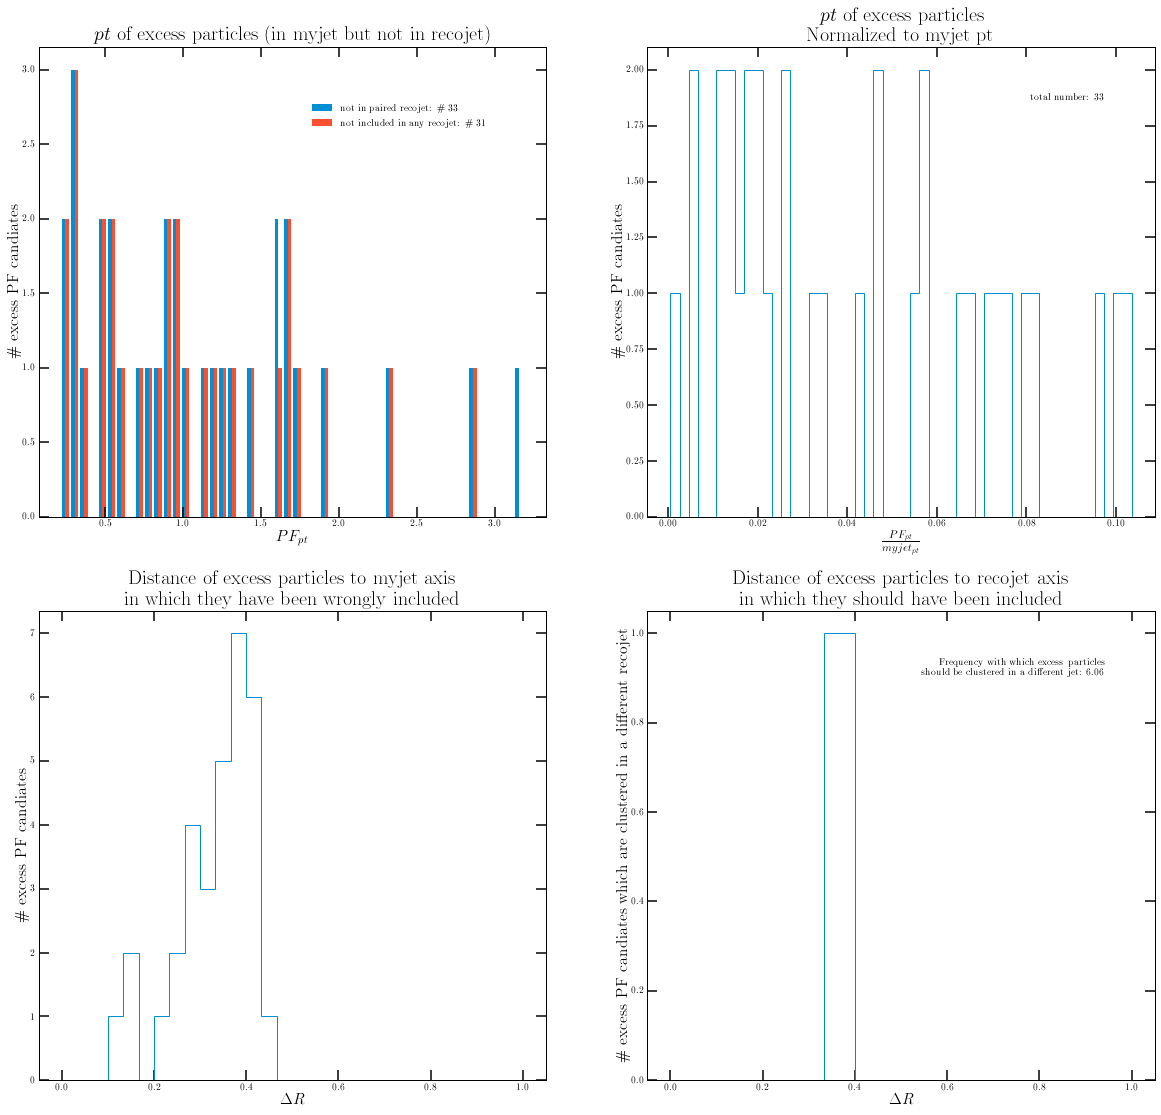

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 19))

# pt non normed
ax[0][0].hist([excesspf_pt, excesspf_pt_unclustered], label=["not in paired recojet: \# {}".format(len(excess_idx)), "not included in any recojet: \# {}".format(len(excesspf_pt_unclustered))], bins=50)
#ax[0][0].set_yscale('log')
ax[0][0].set_title("$pt$ of excess particles (in myjet but not in recojet)")
ax[0][0].set_xlabel("$PF_{pt}$")
ax[0][0].set_ylabel("\# excess PF candiates")
ax[0][0].legend(bbox_to_anchor=(0.9, 0.9))

# pt normed to myjet
ax[0][1].hist(norm_excesspf_pt, bins=50, histtype='step')
ax[0][1].text(0.9, 0.9, "total number: {:.0f}".format(len(excess_idx)), ha='right', va='top', transform = ax[0][1].transAxes)
#ax[0][1].set_yscale('log')
ax[0][1].set_title("$pt$ of excess particles\nNormalized to myjet pt")
ax[0][1].set_xlabel("$\\frac{PF_{pt}}{myjet_{pt}}$")
ax[0][1].set_ylabel("\# excess PF candiates")


# distance to myjet axis
ax[1][0].hist(excesspf_distance, bins=30, range=[0,1], histtype='step')
#ax[1][0].set_yscale('log')
ax[1][0].set_title("Distance of excess particles to myjet axis\nin which they have been wrongly included")
ax[1][0].set_xlabel("$\Delta R$")
ax[1][0].set_ylabel("\# excess PF candiates")

# distance to recojet axis in which particle should have been included
ax[1][1].hist(excesspf_distance_other, bins=30, range=[0,1], histtype='step')
ax[1][1].text(0.9, 0.9, "Frequency with which excess particles\nshould be clustered in a different jet in \%: {:.2%}".format(len(excesspf_distance_other)/len(excess_idx)), ha='right', va='top', transform = ax[1][1].transAxes)
#ax[1][1].set_yscale('log')
ax[1][1].set_title("Distance of excess particles to recojet axis\nin which they should have been included")
ax[1][1].set_xlabel("$\Delta R$")
ax[1][1].set_ylabel("\# excess PF candiates which are clustered in a different recojet")


plt.show()
#fig.savefig("plots/different_pileup_mitigation/constituents/excess_chs.pdf")

##### CHS
Only few excess particles, but the majority of those shouldn't be included in any clusterig. Only occurs for particles close to the jet radius at $R=0.4$.
##### PUPPI
Only a few excess particles, almost all of which shouldn't be considered in the clustering at all. Indicates that puppi does remove almost all of the background, but by considering the missing particles plot, typically excluded too many particle/ labels them as background.

##### NO PUPPI
- blue: particles in myjet that are not in paired recojet
- red: particles in myjet that are not in any recojet

Note that almost all excess particles shouldn't be included in any clustering. Only 0.47% of excess particles are actually constituents of a different jet, meaning that 99.53% of excess particles are pileup (plot 3 shows that these particles are mostly within a distance of 0.4 and thus valid jet constituents when they are not removed as background). Not that excess particles are the dominant error for No puppi clustering. With a suitable pileup mitigation should be able to get jets much closer to recojets.

# Compare kinematics of all particles, recojet constituents, and my jet constituents 

In [39]:
recoconst_pts, recoconst_etas, recoconst_phis = [], [], []

# recojets
# only PF which have been used in clustering (!=-1) and whoes jets are paired with one of myjets
for i in range(max_idx):
    m = my_matchings[i]
    n_particles = len(pf_recojetidx[i])
    mask = np.empty(n_particles, dtype=bool)
    for j in range(n_particles):
        if pf_recojetidx[i][j] == -1:
            mask[j] = False
        elif pf_recojetidx[i][j] in m:
            mask[j] = True
        else:
            mask[j] = False
    
    recoconst_pts.extend(pts[i][mask])
    recoconst_etas.extend(etas[i][mask])
    recoconst_phis.extend(phis[i][mask])    

    
# myjet; stores kinematics of constituents as used in clustering (i.e when puppi is used, then pt*weight stored here)
# only PF of jets that have been paired with a recojet
myconst_pts, myconst_etas, myconst_phis = [], [], []
for i,myjets_oneevent in enumerate(myjets):
    m = my_matchings[i]
    for myj, recoj in enumerate(m):
        if recoj == -1:
            continue
        else:
            consti = myjets_oneevent[myj].constituents_array()
            myconst_pts.extend(consti['pT'])
            myconst_etas.extend(consti['eta'])
            myconst_phis.extend(consti['phi'])

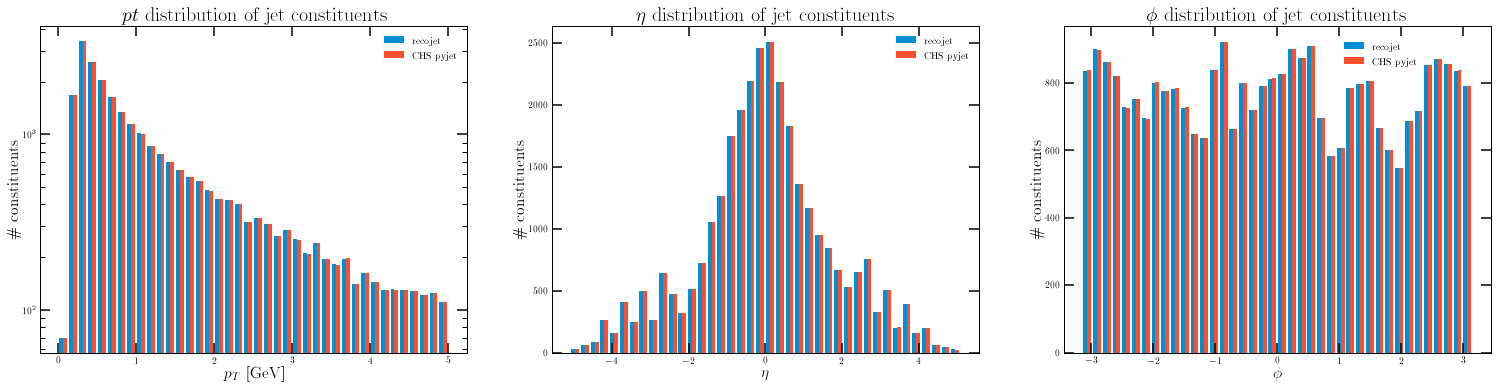

In [60]:
fig, ax = plt.subplots(1,3, figsize=(26,6))

ax[0].hist([recoconst_pts, myconst_pts], range=(0,5), bins=40, label=['recojet', 'CHS pyjet'])
ax[0].set_title("$pt$ distribution of jet constituents")
ax[0].set_yscale('log')
ax[0].set_xlabel("$p_T$ [GeV]")
ax[0].set_ylabel("\# constituents")
ax[0].legend()


ax[1].hist([recoconst_etas, myconst_etas], bins=40, label=['recojet', 'CHS pyjet'])
ax[1].set_title("$\eta$ distribution of jet constituents")
#ax[1].set_yscale('log')
ax[1].set_xlabel("$\eta$")
ax[1].set_ylabel("\# constituents")
ax[1].legend()


ax[2].hist([recoconst_phis, myconst_phis], bins=40, label=['recojet', 'CHS pyjet'])
ax[2].set_title("$\phi$ distribution of jet constituents")
#ax[2].set_yscale('log')
ax[2].set_xlabel("$\phi$")
ax[2].set_ylabel("\# constituents")
ax[2].legend(bbox_to_anchor=(0.85, 0.85))


plt.show()
#fig.savefig("plots/different_pileup_mitigation/consti_kinematics_chs.pdf")

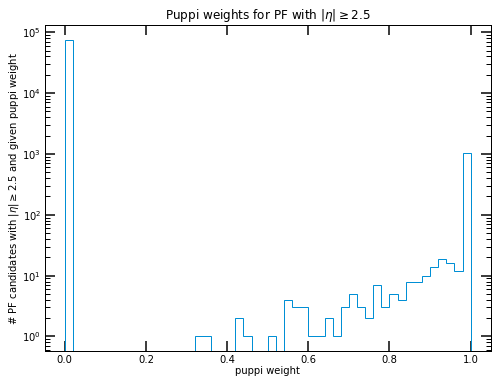

In [13]:
# Investigate why eta distribution for puppi jets small for |eta| > 2.5 by plotting puppi weights for such PF
eta_max = 2.5
large_eta_weights = []
if using_puppi:
    for i in range(max_idx):
        large_eta_mask = np.where(etas[i] >= eta_max, True, False)
        large_eta_weights.extend(puppi_weights[i][large_eta_mask])

        
fig = plt.figure(figsize=(8,6))

plt.hist(large_eta_weights, bins=50, histtype='step')
plt.yscale('log')
plt.title("Puppi weights for PF with $|\eta| \geq {}$".format(eta_max))
plt.xlabel("puppi weight")
plt.ylabel("# PF candidates with $|\eta| \geq {}$ and given puppi weight".format(eta_max))
plt.show()

#### Conclusion
##### CHS
All distribution have the desired shape of the recojet distribution.

# Problem: distributions have to large abs number, but from constuituents analysis found that less than 30 particles have been clustered incorrectly.


#####  PUPPI
Generally not enough particles are clustered. The $\phi, \eta$ distributions are similar to reco, ecept that my puppi jets miss particles with $|\eta| > 2$ (due to ignoring particles with zero weight). The $pt$ distribution is similar to the recojet one but at very small $pt$, there is a significant difference as my clustering misses predominantly solft particles.

#####  NO PUPPI
All distributions are similar (follow trend of recojet constituents more than puppi jet constituents), only that my plain jets consitently overestimate the number of constituents.

# Jet differences

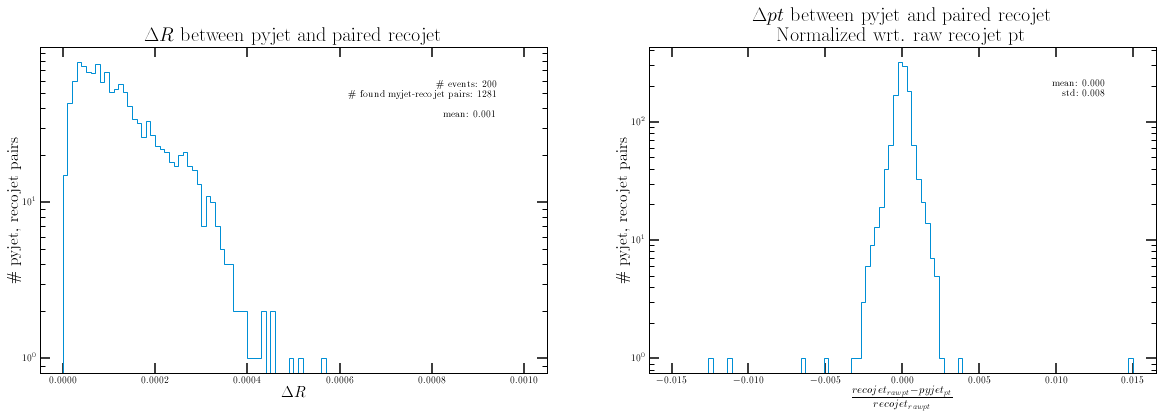

In [62]:
# # simpler plot
# fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# ax[0].hist(delta_Rs, range=(0,0.001), bins=100, histtype='step') 
# ax[0].set_yscale('log')
# stats_str = "\# events: {}\n\# found myjet-recojet pairs: {:.0f}\n\nmean: {:.3f}".format(max_idx, len(delta_Rs), np.mean(delta_Rs))
# ax[0].text(0.9, 0.9, stats_str, ha='right', va='top', transform = ax[0].transAxes)
# ax[0].set_title("$\Delta R$ between pyjet and paired recojet")
# ax[0].set_xlabel("$\Delta R$")
# ax[0].set_ylabel("\# pyjet, recojet pairs")


# ax[1].hist(delta_pts, bins=100, range=(-0.015, 0.015), histtype='step')
# ax[1].set_yscale('log')
# stats_str = "mean: {:.3f}\nstd: {:.3f}".format(np.mean(delta_pts), np.std(delta_pts))
# ax[1].text(0.9, 0.9, stats_str, ha='right', va='top', transform = ax[1].transAxes)
# ax[1].set_title("$\Delta pt$ between pyjet and paired recojet\nNormalized wrt. raw recojet pt")
# ax[1].set_xlabel("$\\frac{recojet_{rawpt} - pyjet_{pt}}{recojet_{rawpt}}$")
# ax[1].set_ylabel("\# pyjet, recojet pairs")

# plt.show()
# #fig.savefig("jet_properties_chs.pdf")

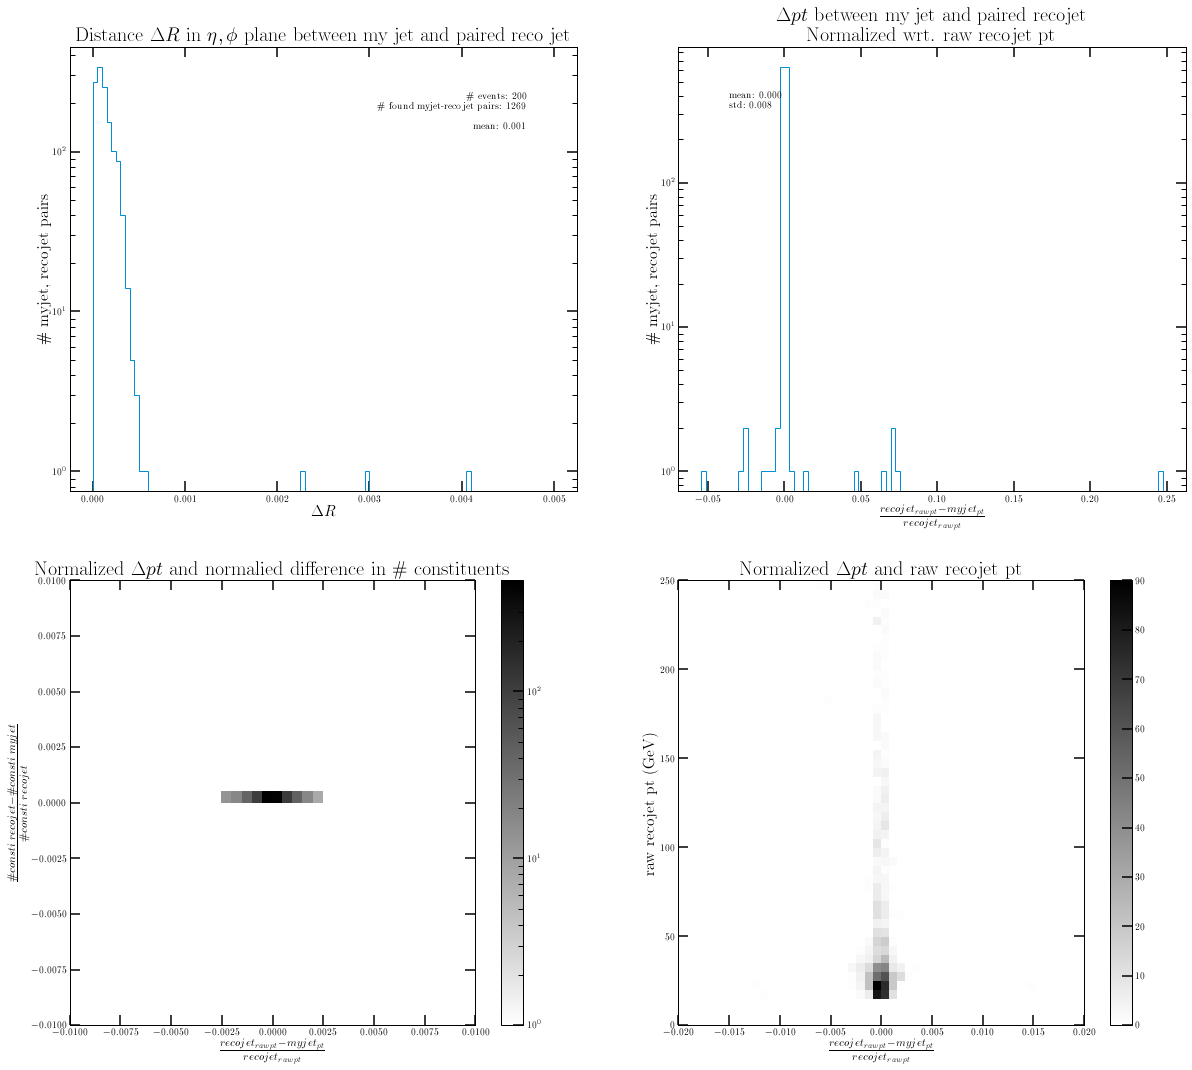

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(20, 9*2))

njets, _, _ = ax[0][0].hist(delta_Rs, range=(0,0.005), bins=100, histtype='step') 
ax[0][0].set_yscale('log')
stats_str = "\# events: {}\n\# found myjet-recojet pairs: {:.0f}\n\nmean: {:.3f}".format(max_idx, np.sum(njets), np.mean(delta_Rs))
ax[0][0].text(0.9, 0.9, stats_str, ha='right', va='top', transform = ax[0][0].transAxes)
ax[0][0].set_title("Distance $\Delta R$ in $\eta, \phi$ plane between my jet and paired reco jet")
ax[0][0].set_xlabel("$\Delta R$")
ax[0][0].set_ylabel("\# myjet, recojet pairs")


ax[0][1].hist(delta_pts, bins=100, histtype='step')
ax[0][1].set_yscale('log')
stats_str = "mean: {:.3f}\nstd: {:.3f}".format(np.mean(delta_pts), np.std(delta_pts))
ax[0][1].text(0.9, 0.9, stats_str, ha='right', va='top', transform = ax[0][1].transAxes)
ax[0][1].set_title("$\Delta pt$ between my jet and paired recojet\nNormalized wrt. raw recojet pt")
ax[0][1].set_xlabel("$\\frac{recojet_{rawpt} - myjet_{pt}}{recojet_{rawpt}}$")
ax[0][1].set_ylabel("\# myjet, recojet pairs")


h = ax[1][0].hist2d(delta_pts, delta_n, bins=40, range=[[-0.01, 0.01], [-0.01, 0.01]], norm=mpl.colors.LogNorm(), cmap='gist_yarg')  # no range for puppi, no puppi: range=[[-0.25, 0.25], [-0.4, 0.2]]
ax[1][0].set_title("Normalized $\Delta pt$ and normalied difference in \# constituents")
ax[1][0].set_xlabel("$\\frac{recojet_{rawpt} - myjet_{pt}}{recojet_{rawpt}}$")
ax[1][0].set_ylabel("$\\frac{\# consti\:recojet - \# consti\:myjet}{\# consti\:recojet}$")
fig.colorbar(h[3], ax=ax[1][0])


h = ax[1][1].hist2d(delta_pts, raw_reco_pts, bins=50, range=[[-0.02, 0.02], [0, 250]], cmap='gist_yarg') # puppi: range=[[-0.1, 0.4], [0, 250]], no puppi: range=[[-0.4, 0.1], [0, 250]], chs: range=[[-0.05, 0.05], [0, 250]]
ax[1][1].set_title("Normalized $\Delta pt$ and raw recojet pt")
ax[1][1].set_xlabel("$\\frac{recojet_{rawpt} - myjet_{pt}}{recojet_{rawpt}}$")
ax[1][1].set_ylabel("raw recojet pt (GeV)")
fig.colorbar(h[3], ax=ax[1][1])


plt.show()
#fig.savefig("plots/different_pileup_mitigation/jet_properties_chs.pdf")

#### Conclusion

##### CHS
All plots centred on 0 and very narrow i.e. correct clustering found.

#####  PUPPI
The separation of my jets and recojets is good, but the pt of my jets is typically smaller than the recojet pt, which can be seen as a result of the large number of missed constituents (refelcted in plot 3). The last plot shows that this problem occus mostly with weak jet with $pt<75$ GeV.

#####  NO PUPPI
Note that since there are more no puppi jets, the counts of the histograms are typically larger than for puppi jets.
Puppi jets lead to slightly smaller jet separation and slightly more centred/ narrower $\Delta pt$ distribution. Typically, the number of constituents is overestimated, leading to a larger pt than recojet. It appears that plots 3,4 are more centred than for puppi jets, but an appropiate normalization has to be chosen to compare the plots for puppi and no puppi jets. However, it remains that the majority of the problems occur at jet with $pt<75$ GeV.  